# Possible variations of basic Classifiers:
    - Probabilistic Classification
    - Classification for Unbalanced data

## Probabilistic Classification 
Instead of giving as a output a class label, the probabilistic classification gives as output a probability/score.
To achieved the final classification, the corresponding label of the highest probability is chosen. The probability itself may be used as a degree of confidence about the classification result. <img src="../Figures/prob_class.png" alt="Drawing" style="width: 500px;"/>

Observation: All experiments performed with 100 samples to limite the processing time

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import os
import numpy as np
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.transforms as mtransforms

In [2]:
## Classifying samples based on scanner vendor: GE, PHILIPS, SIEMENS
data = np.load(os.path.join('../Data/'+"feats_cc359.npy"))
nsamples = 100

## classyfing images by magnetic field 1.5T or 3T ##
np.random.seed(0)
np.random.shuffle(data) # randomize samples

y = (data[:nsamples,0]-10).astype(np.uint8) # create label vector by using data information (0 - GE; 1 - PHILIPS; 2- SIEMENS)
X = data[:nsamples,4:] # extract feats from data (only removing other image/patients infos)

### SVM - probability ###
## Parameter for Grid-Search ##
tuned_parameters = [
    {'C': [1, 100], 'kernel': ['linear']},
    #{'C': [1, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf']},
    ]

## Cross validation using 2-fold ##
kf = KFold(n_splits=2)
final_cm = np.zeros((3,3))
acc = []
for train, test in kf.split(X,y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    clf = GridSearchCV(SVC(probability=True), tuned_parameters,scoring='accuracy') # grid search maximizing the accuracy
    clf.fit(X_train, y_train) # training
    y_pred = clf.predict_proba(X_test) # testing
    acc.append(accuracy_score(y_test, np.argmax(y_pred,axis=1)))

print 'final accuracy:',np.array(acc).mean()

final accuracy: 1.0


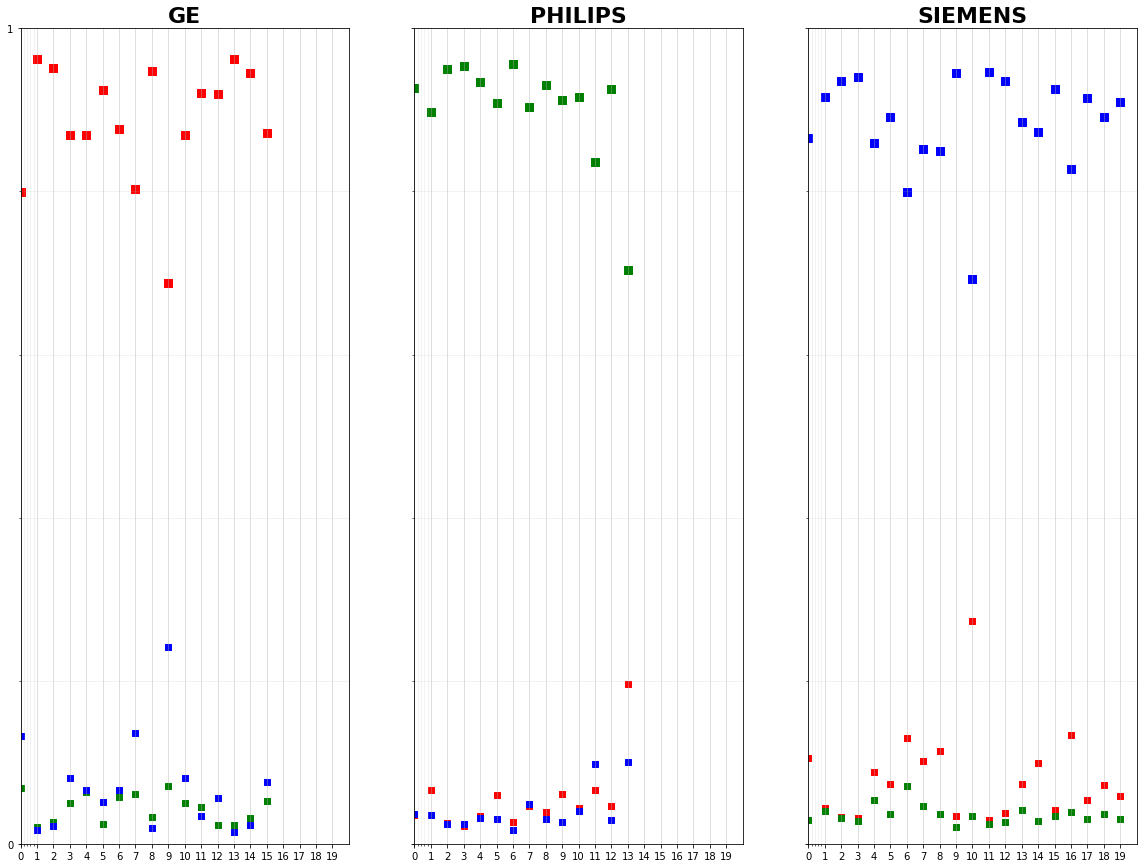

In [3]:
## Visualizing the probabilities per class ##

def viz_prob(ax,v):
    """
    This function plots the probabilities achieved per class.
    """
    label = ['r','g','b']
    ax.scatter(np.arange((y_test==v[0]).sum()), y_pred[np.argwhere(y_test==v[0]),v[0]], c=label[v[0]], marker='s',s=60)
    ax.scatter(np.arange((y_test==v[0]).sum()), y_pred[np.argwhere(y_test==v[0]),v[1]], c=label[v[1]], marker='s')
    ax.scatter(np.arange((y_test==v[0]).sum()), y_pred[np.argwhere(y_test==v[0]),v[2]], c=label[v[2]], marker='s')
    major_ticks = np.arange(0, 20, 1)                                              
    minor_ticks = np.arange(0, 1, 0.2)                                               
    ax.set_xticks(major_ticks)                                                       
    ax.set_xticks(minor_ticks, minor=True)                                           
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)     
    ax.grid(which='minor', alpha=0.2)                                                
    ax.grid(which='major', alpha=0.5)
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 1.)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, sharey=True, figsize=(20,15))

ax1.set_title('GE', fontsize=22, fontweight='bold')
v = [0,1,2]
viz_prob(ax1,v)

ax2.set_title('PHILIPS', fontsize=22, fontweight='bold')
viz_prob(ax2,v=[1,0,2])

ax3.set_title('SIEMENS', fontsize=22, fontweight='bold')
viz_prob(ax3,v=[2,0,1])

## Unbalanced samples
Another problem very often faced on supervised classification problems is unbalanced samples per class (majority of the samples are from a specific class).
To face this problem, it is introduced the stratified cross validation and class weighted SVM: 

- Stratified cross validation: This cross-validation is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
- Class weighted SVM: all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [4]:
## Unbalanced datasets - Classifying samples based on age using a 45 threshold ##
nsamples = 100

## classyfing images by magnetic field 1.5T or 3T ##
np.random.seed(0)
np.random.shuffle(data) # randomize samples

y = (data[:nsamples,2]>45).astype(np.uint8) # create label vector by using data information (age>45)
print 'class distribution #samples with(<45,>45):',np.bincount(y)
X = data[:nsamples,4:] # extract feats from data 

### SVM - probability ###
## SOLUTION: Stratified kfold and unbalanced SVM ##
tuned_parameters = [
    {'C': [1, 100], 'kernel': ['linear']},
    ]

## Cross validation using 2-fold ##
kf = StratifiedKFold(n_splits=2)
final_cm = np.zeros((2,2))
acc = []
for train, test in kf.split(X,y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    clf = GridSearchCV(SVC(probability=True,class_weight='balanced'), tuned_parameters,scoring='accuracy') # grid search maximizing the accuracy
    clf.fit(X_train, y_train) # training
    y_pred = clf.predict_proba(X_test) # testing
    acc.append(accuracy_score(y_test, np.argmax(y_pred,axis=1)))
print 'accuracy:', np.array(acc).mean()

class distribution #samples with(<45,>45): [14 86]
accuracy: 0.88


# Question
1. Change the threshold in the age classification, and verify results variation